### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 3

#### Дисциплина: Интеллектуальный анализ данных

##### Студент: Матюхин Григорий Васильевич
##### Группа: НПИбд-01-21

## Москва 2024
***

### Вариант №14

- Communities and Crime Data Set (https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime), название файла: communities.data
- Превый признак: population (столбец 6)
- Второй признак: ViolentCrimesPerPop (столбец 128)
- Класс: LemasGangUnitDeploy (столбец 125)
- Алгоритмы: K-means, BIRCH, OPTICS, Spectral Clustering
- Меры качества: F-мера, парные меры TP, FN, FP, TN, индекс Жаккара
- Найти лучший алгоритм кластеризации относительно меры качества: F-мера

## 1. Подготавливаем датасет

In [1]:
from ucimlrepo import fetch_ucirepo

communities = fetch_ucirepo(id=183)

In [2]:
communities["data"].keys()

dict_keys(['ids', 'features', 'targets', 'original', 'headers'])

In [3]:
communities["data"]["features"].keys()

Index(['state', 'county', 'community', 'communityname', 'fold', 'population',
       'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian',
       ...
       'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans',
       'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop'],
      dtype='object', length=127)

In [4]:
communities["data"]["targets"].keys()

Index(['ViolentCrimesPerPop'], dtype='object')

In [5]:
import pandas as pd

In [6]:
CLS = "LemasGangUnitDeploy"
F1 = "population"
F2 = "ViolentCrimesPerPop"

In [7]:
df = pd.DataFrame(communities["data"]["features"][CLS])
df[F1] = communities["data"]["features"][F1]
df[F2] = communities["data"]["targets"][F2]
df

,LemasGangUnitDeploy,population,ViolentCrimesPerPop
0,0.5,0.19,0.20
1,?,0.00,0.67
2,?,0.00,0.43
3,?,0.04,0.12
4,?,0.01,0.03
...,...,...,...
1989,?,0.01,0.09
1990,?,0.05,0.45
1991,0,0.16,0.23
1992,0,0.08,0.19


## 2. Испарвляем пропуски

In [8]:
import numpy as np

In [9]:
df = df.replace("?", np.nan)

In [10]:
df[CLS].notna().all()

np.False_

In [11]:
df[F1].notna().all()

np.True_

In [12]:
df[F2].notna().all()

np.True_

Надо исправить пропуски в метке класса -- удаляем строки.

In [13]:
df = df.dropna()

## 3. Объединение классов

In [14]:
df[CLS].unique()

array(['0.5', '0', '1'], dtype=object)

Классов всего 3 -- объединение не требуется

## 4. Визуализация

In [15]:
import matplotlib.pyplot as plt

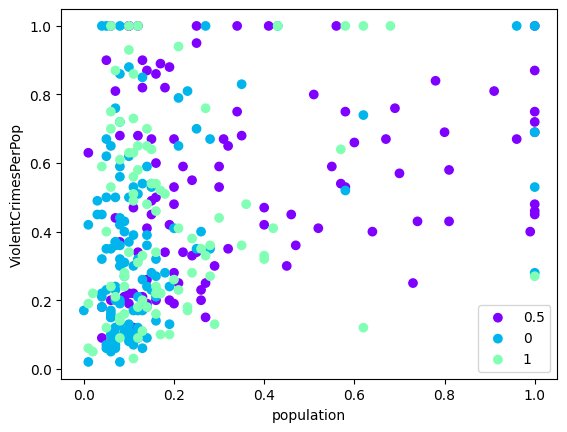

In [16]:
klass = list(df[CLS].unique())

for k in klass:
    df_k = df[df[CLS] == k]
    plt.scatter(df_k[F1], df_k[F2], label=k, c=[klass.index(k) for i in range(len(df_k))], cmap='rainbow', vmin=0, vmax=4)

plt.xlabel(F1)
plt.ylabel(F2)

plt.legend()
plt.show()

## 5. Кластеризация

In [17]:
def draw_clusters(df, predicted_labels, title):
    # two panels, left with predicted data, right with correct and incorrect predictions in red and blue
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    all_f1 = list(df[F1])
    all_f2 = list(df[F2])
    all_class = list(df[CLS])


    for k in range(len(klass)):
        thick = []
        width = []
        for i in range(len(df)):
            if all_class[i] == klass[k]:
                thick.append(all_f1[i])
                width.append(all_f2[i])
        ax1.scatter(thick, width, label=klass[k], c=[k for i in range(len(thick))], cmap='rainbow', vmin=0, vmax=4)

    ax1.set_xlabel(F1)
    ax1.set_ylabel(F2)

    ax1.legend()

    ax1.set_title(title)

    prediction_correct_f1 = []
    prediction_correct_f2 = []
    prediction_incorrect_f1 = []
    prediction_incorrect_f2 = []

    for i in range(len(df)):
        if all_class[i] == predicted_labels[i]:
            prediction_correct_f1.append(all_f1[i])
            prediction_correct_f2.append(all_f2[i])
        else:
            prediction_incorrect_f1.append(all_f1[i])
            prediction_incorrect_f2.append(all_f2[i])

    ax2.scatter(prediction_correct_f1, prediction_correct_f2, label='OK', c='green')
    ax2.scatter(prediction_incorrect_f1, prediction_incorrect_f2, label='NG', c='red')

    ax2.set_xlabel(F1)
    ax2.set_ylabel(F2)

    ax2.legend()
    ax2.set_title(str(round((len(prediction_correct_f1) / len(all_f1)) * 100, 4)) + '% OK')

    plt.show()

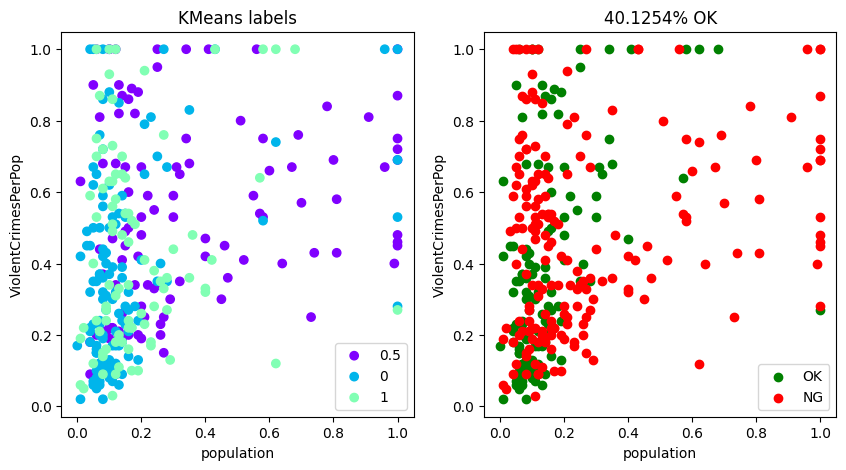

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=len(klass))
kmeans_labels = kmeans.fit_predict(df[[F1, F2]])
kmeans_labels = [klass[i] for i in kmeans_labels]
draw_clusters(df, kmeans_labels, "KMeans labels")

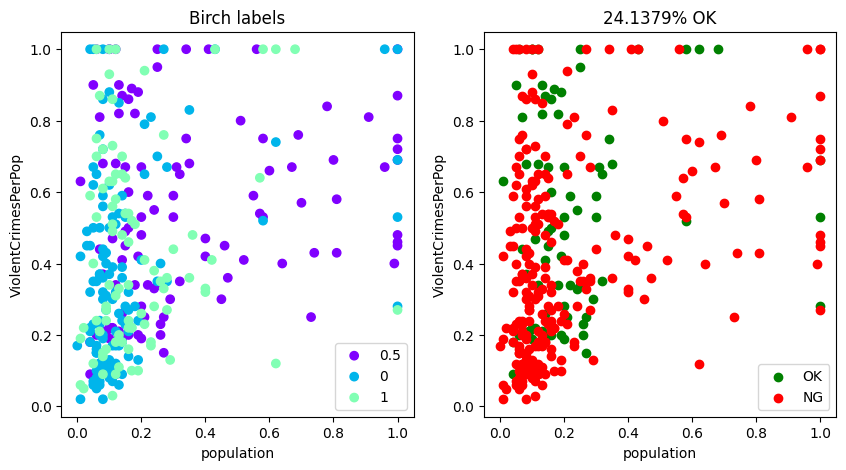

In [19]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=len(klass), threshold=0.2)
birch_labels = birch.fit_predict(df[[F1, F2]])
birch_labels = [klass[i] for i in birch_labels]
draw_clusters(df, birch_labels, "Birch labels")

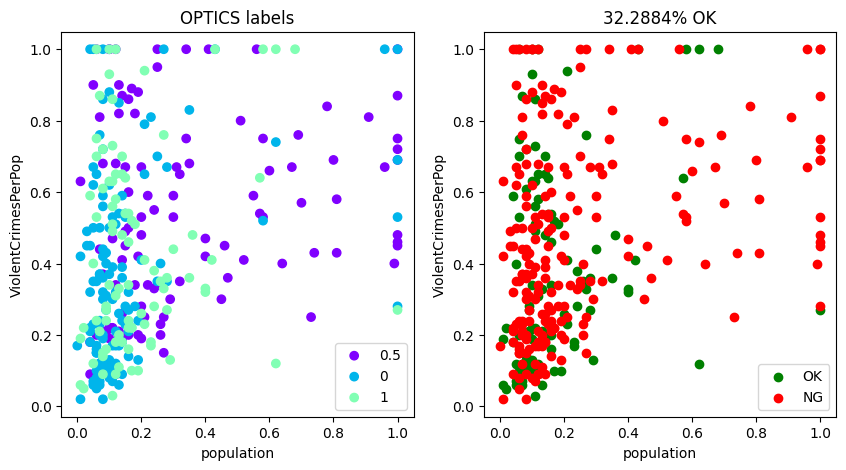

In [20]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=24)
optics_labels = optics.fit_predict(df[[F1, F2]])
optics_labels = [klass[i] for i in optics_labels]
draw_clusters(df, optics_labels, "OPTICS labels")

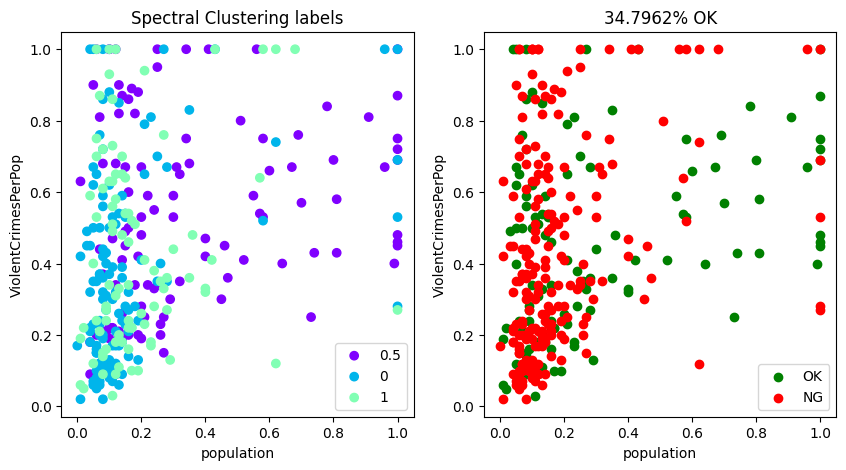

In [21]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=len(klass), gamma=0.5)
spectral_labels = spectral.fit_predict(df[[F1, F2]])
spectral_labels = [klass[i] for i in spectral_labels]
draw_clusters(df, spectral_labels, "Spectral Clustering labels")

## 6. Матрица сопряженности

In [22]:
from sklearn.metrics.cluster import contingency_matrix

true_labels = list(df[CLS])
kmeans_contingency = contingency_matrix(true_labels, kmeans_labels)
pd.DataFrame(kmeans_contingency).style.background_gradient(cmap="Blues")

,0,1,2
0,87,32,7
1,39,36,30
2,51,32,5


In [23]:
birch_contingency = contingency_matrix(true_labels, birch_labels)
pd.DataFrame(birch_contingency).style.background_gradient(cmap="Blues")

,0,1,2
0,4,118,4
1,25,69,11
2,7,77,4


In [24]:
optics_contingency = contingency_matrix(true_labels, optics_labels)
pd.DataFrame(optics_contingency).style.background_gradient(cmap="Blues")

,0,1,2
0,19,23,84
1,2,11,92
2,3,12,73


In [25]:
spectral_contingency = contingency_matrix(true_labels, spectral_labels)
pd.DataFrame(spectral_contingency).style.background_gradient(cmap="Blues")

,0,1,2
0,32,7,87
1,34,27,44
2,31,5,52


In [26]:
from sklearn.metrics import f1_score

print("F-measure:")
print("KMeans: ", f1_score(true_labels, kmeans_labels, average="weighted"))
print("Birch: ", f1_score(true_labels, birch_labels, average="weighted"))
print("OPTICS: ", f1_score(true_labels, optics_labels, average="weighted"))
print("Spectral: ", f1_score(true_labels, spectral_labels, average="weighted"))

F-measure:
KMeans:  0.3636480100102913
Birch:  0.16322869641844984
OPTICS:  0.267531794122733
Spectral:  0.3426572184631837


In [27]:
def pairwise_tf_fn(true_labels, test_labels):
    out = []
    for k in klass:
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for i in range(len(true_labels)):
            if true_labels[i] == k and test_labels[i] == k:
                tp += 1
            elif true_labels[i] != k and test_labels[i] == k:
                fp += 1
            elif true_labels[i] == k and test_labels[i] != k:
                fn += 1
            else:
                tn += 1
        out.append([tp, fp, fn, tn])
    return np.array(out).sum(axis=0)

In [28]:
print("Pairwise TN, FN, FP, TP:")
print("KMeans: ", pairwise_tf_fn(true_labels, kmeans_labels))
print("Birch: ", pairwise_tf_fn(true_labels, birch_labels))
print("OPTICS: ", pairwise_tf_fn(true_labels, optics_labels))
print("Spectral: ", pairwise_tf_fn(true_labels, spectral_labels))

Pairwise TN, FN, FP, TP:
KMeans:  [128 191 191 447]
Birch:  [ 77 242 242 396]
OPTICS:  [103 216 216 422]
Spectral:  [111 208 208 430]


In [29]:
from sklearn.metrics import jaccard_score

print("Jaccard score:")
print("KMeans: ", jaccard_score(true_labels, kmeans_labels, average="weighted"))
print("Birch: ", jaccard_score(true_labels, birch_labels, average="weighted"))
print("OPTICS: ", jaccard_score(true_labels, optics_labels, average="weighted"))
print("Spectral: ", jaccard_score(true_labels, spectral_labels, average="weighted"))

Jaccard score:
KMeans:  0.24024095268127096
Birch:  0.0964180224008679
OPTICS:  0.15942991377316199
Spectral:  0.20763540452569926


## 7. Лучший алгоритм

In [30]:
f1_scores = [
    ("KMeans", f1_score(true_labels, kmeans_labels, average="weighted")),
    ("Birch", f1_score(true_labels, birch_labels, average="weighted")),
    ("OPTICS", f1_score(true_labels, optics_labels, average="weighted")),
    ("Spectral", f1_score(true_labels, spectral_labels, average="weighted")),
]

f1_scores.sort(key=lambda x: x[1], reverse=True)
print("Best:")
for i, score in enumerate(f1_scores):
    print(f"{i+1}. {score[0]}: {score[1]}")

Best:
1. KMeans: 0.3636480100102913
2. Spectral: 0.3426572184631837
3. OPTICS: 0.267531794122733
4. Birch: 0.16322869641844984


## 8. Области принятия решений

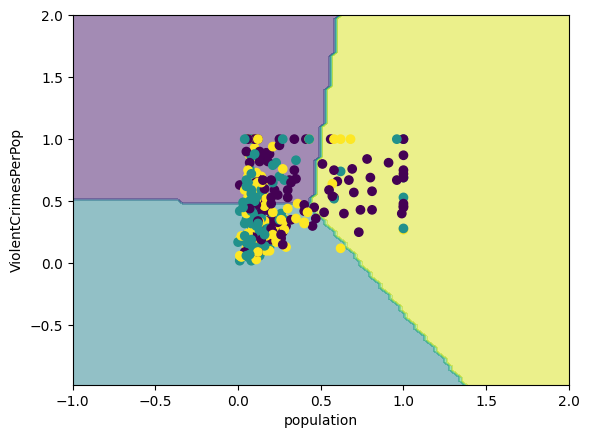

In [31]:
from sklearn.inspection import DecisionBoundaryDisplay

disp = DecisionBoundaryDisplay.from_estimator(kmeans, df[[F1, F2]], response_method="predict", cmap="viridis", alpha=0.5)
disp.ax_.scatter(df[F1], df[F2], c=[klass.index(k) for k in df[CLS]], cmap="viridis")
plt.show()